Ter voorbereiding (om de correlatie matrices te maken):
pip install dython
meer info op:
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
code: https://github.com/shakedzy/dython

In [1]:
import numpy as np
import pandas as pd
from dython.nominal import associations
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor

Training set:
- mix uit numerische en categorische variabelen

In [2]:
df_train = pd.read_csv("train.csv")
print(df_train.dtypes)
print(df_train.nunique())

id                       int64
name                    object
brand                   object
base_name               object
screen_size            float64
pixels_x                 int64
pixels_y                 int64
screen_surface          object
touchscreen              int64
cpu                     object
cpu_details             object
detachable_keyboard    float64
discrete_gpu             int64
gpu                     object
os                      object
os_details              object
ram                      int64
ssd                      int64
storage                  int64
weight                 float64
min_price              float64
max_price              float64
dtype: object
id                     510
name                   510
brand                   18
base_name              385
screen_size             17
pixels_x                17
pixels_y                14
screen_surface           4
touchscreen              2
cpu                     23
cpu_details            132
detacha

Test set:
Geen intersectie met training set. Alle id's zijn verschillend.

In [173]:
df_test = pd.read_csv("test.csv")
np.intersect1d(df_train.id.values, df_test.id.values)

array([], dtype=int64)

Dython package: associations berekent correlatie matrix, incl. de categorische variabelen. De matrix is niet 100% symmetrisch. Sommige categorische variabelen zijn enigszins gecorreleerd met een andere, maar niet omgekeerd, bv postcodes leiden tot provincie, maar niet omgekeerd. Maar in de praktijk lijkt dit hier toch niet zo goed te lukken.

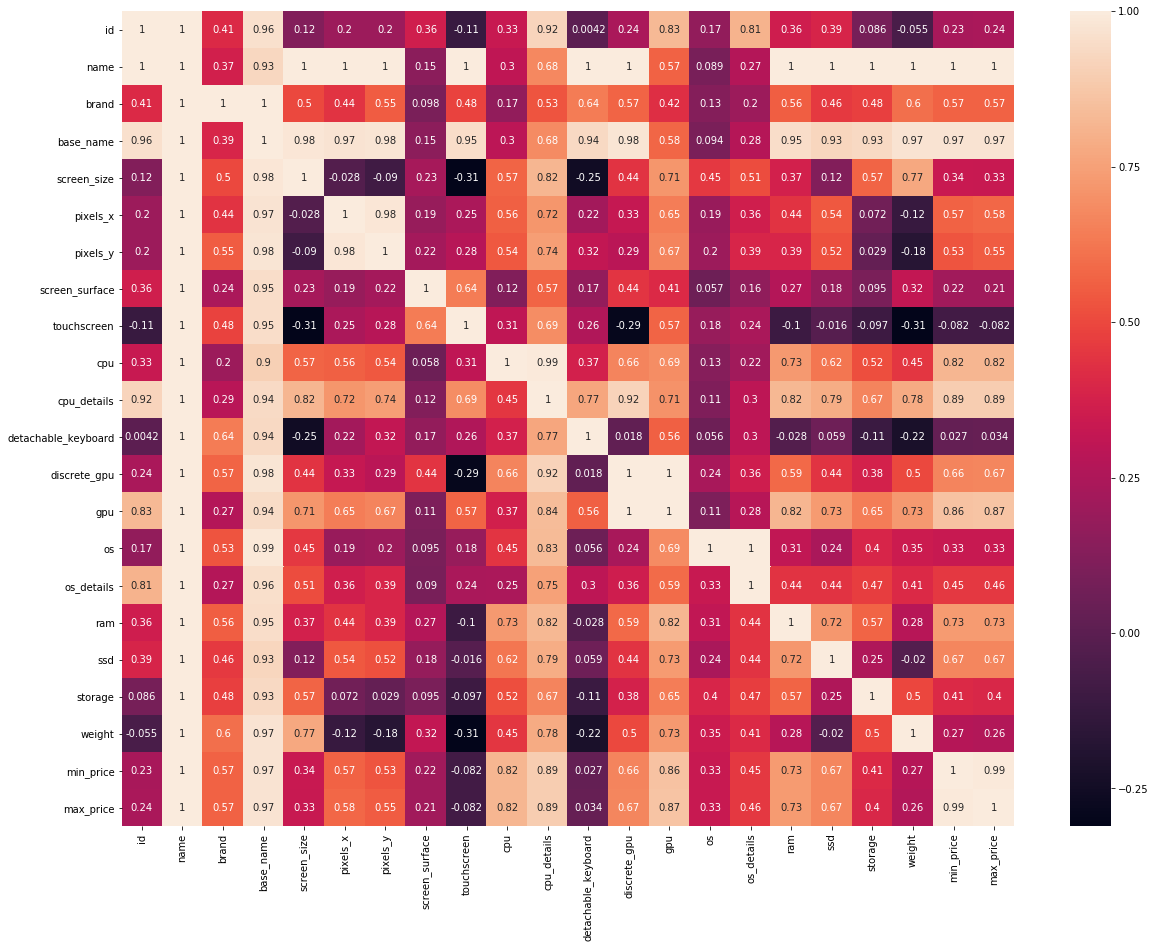

In [193]:
nominal_columns = list(df_train.select_dtypes(include=['object']).columns)
corr=associations(df_train, return_results=True, theil_u=True, plot=False, nominal_columns=nominal_columns)
plt.subplots(figsize=(20,15))
sns.heatmap(corr, annot=True)

Een nieuw DataFrame wordt aangelegd:
    - twee nieuwe targets worden aangelegd: "delta_abs" en "delta_res"
    - "cpu", "gpu" en "os_detail" worden in stukken gedeeld om het aantal values voor de categorische variabelen kleiner te maken
    - de sterk gecorreleerde variabelen verdwijnen (uit matrix boven, alsmede "cpu", "gpu" en "os_detail")
Een nieuwe correlatie-matrix word berekend.

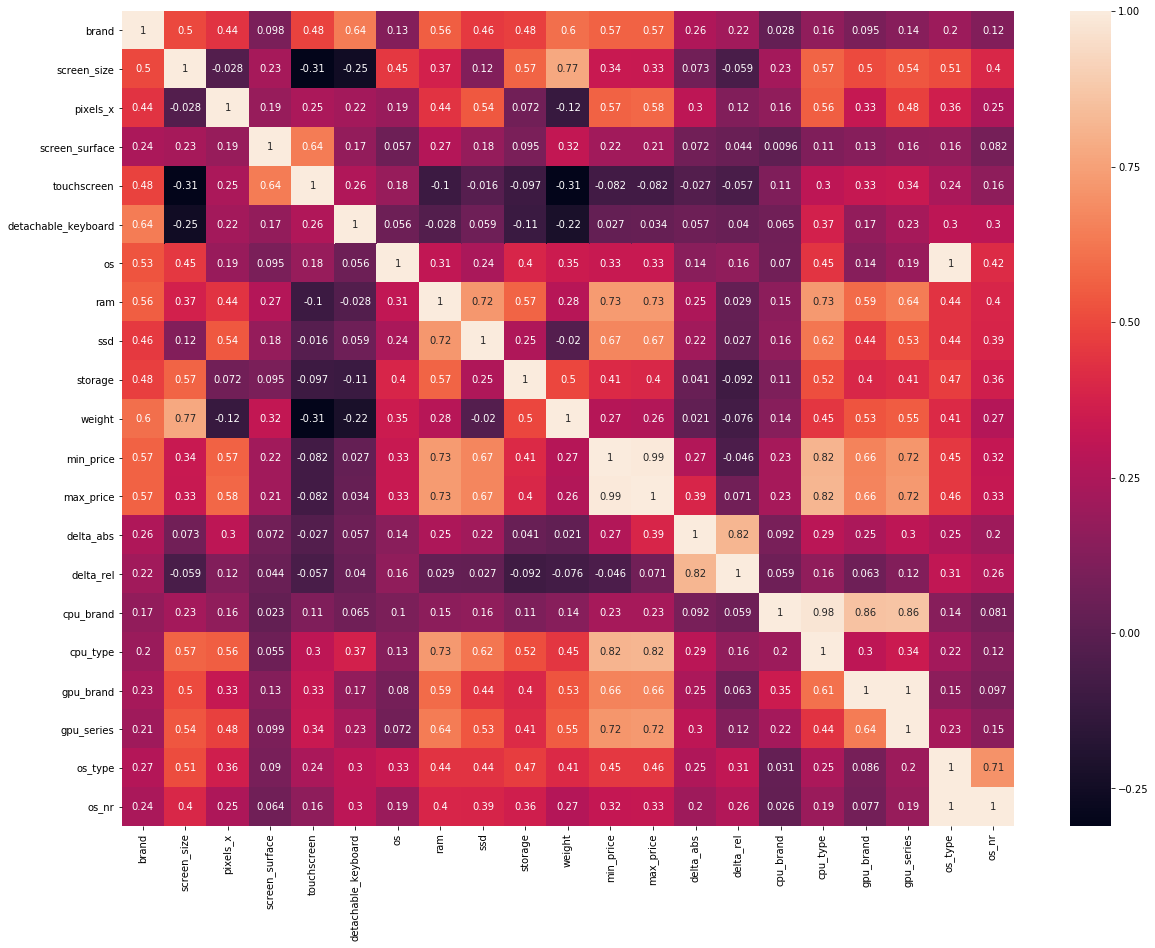

In [194]:
df_pp = deepcopy(df_train)
df_pp["delta_abs"] = df_pp["max_price"] - df_pp["min_price"] 
df_pp["delta_rel"] = np.log(df_pp["max_price"] / df_pp["min_price"] )
df_pp["cpu_brand"] = df_pp.cpu.str.split(n=1).str[0]
df_pp["cpu_type"] = df_pp.cpu.str.split(n=1).str[1]
df_pp["gpu_brand"] = df_pp.gpu.str.split(n=1).str[0]
df_pp["gpu_series"] = df_pp.gpu.str.split(n=2).str[1]
df_pp["os_type"] = df_pp.os_details.str.split(n=1).str[1]
df_pp["os_nr"] = df_pp.os_details.str.split(n=2).str[2]
nominal_columns = nominal_columns + ["cpu_brand", "cpu_type", "gpu_brand", "gpu_series", "os_type", "os_nr"]
df_pp = df_pp.drop(columns=["id", "name", "base_name", "os_details", "cpu_details", "pixels_y",
                        "discrete_gpu", "cpu", "gpu", "os_details"])
nominal_columns_pp = list(set(nominal_columns) & set(list(df_pp)))
targets = ["max_price", "delta_abs", "delta_rel", "min_price"]
corr_pp=associations(df_pp, return_results=True, theil_u=True, plot=False, nominal_columns=nominal_columns_pp)
plt.subplots(figsize=(20,15))
sns.heatmap(corr_pp, annot=True)

Interessant te zien hoe de assymetrische correlatie werkt: uit 'os_type' kan men 'os' afleiden, omgekeerd niet. Insgelijks voor cpu_brand en cpu_type en os_type en os_nummer. Daarom worden de afgeleide kolommen verwijderd

In [195]:
df_pp = df_pp.drop(columns=["os", "cpu_brand", "os_nr"])
nominal_columns = list(set(nominal_columns) - set(["os", "cpu_brand", "os_nr"]))
nominal_columns_pp = list(set(nominal_columns) & set(list(df_pp)))

X en Y variabelen worden gemaakt. Training en validatie set worden uit trainings_dataset gedistilleerd.

In [196]:
#df_pp.fillna(method='ffill', inplace=True)
df_pp[nominal_columns_pp] = df_pp[nominal_columns_pp].astype(str)
X = df_pp.drop(targets, axis=1)
Y1 = df_pp.max_price
Y2 = df_pp.delta_abs
Y3 = df_pp.delta_rel
Y4 = df_pp.min_price
X_train, X_val, Y1_train, Y1_val, Y2_train, Y2_val, Y3_train, Y3_val, Y4_train, Y4_val= train_test_split(X, Y1, Y2, Y3, Y4, test_size=0.20, random_state=1)

De verdeling van de targets is niet zeer mooi. Bij de meeste laptops is price_min = price_max.

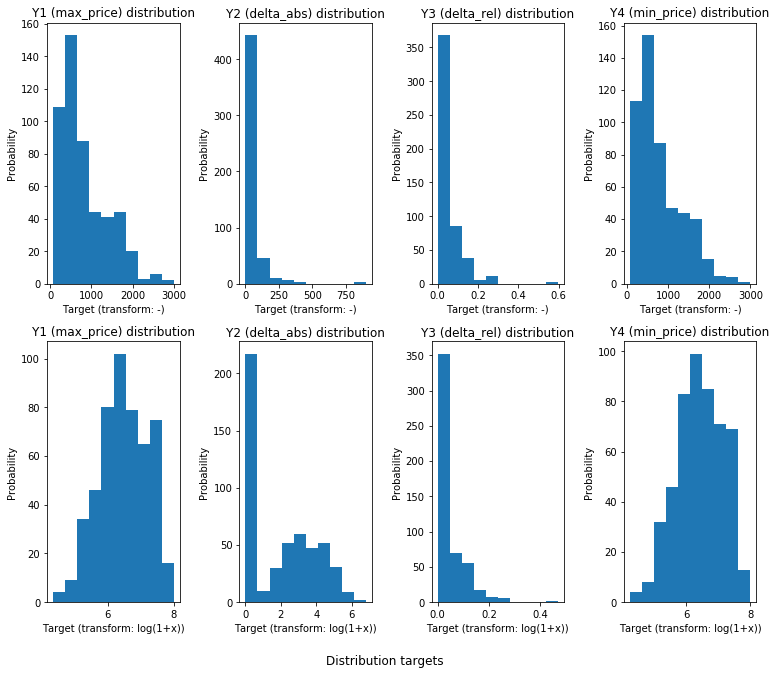

In [197]:
f, ax = plt.subplots(2, 4, figsize=(12,10))

def nothing(x):
    return x

for row, fc, fc_name in zip([0,1], [nothing, np.log1p], ["-", "log(1+x)"]):
    for column in range(4):
        ax[row,column].hist(fc(df_pp[targets[column]]).values, bins=10)
        ax[row,column].set_ylabel('Probability')
        ax[row,column].set_xlabel('Target (transform: {})'.format(fc_name))
        ax[row,column].set_title('Y{} ({}) distribution'.format(column+1, targets[column]))
f.suptitle("Distribution targets", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
        

Een functie om de error te berekenen (indien delta=False, dan wordt min_price direct geschat, indien delta=True, dan wordt delta tussen max_price en min_price geschat). Indien Y2 en pipe_2 niet doorgegeven worden, dan wordt de formule enkel op één schatting toegepast

In [198]:
def seppe_error(X_val, Y1_true, pipe_1, Y2_true=None, pipe_2=None, delta=False):
    from sklearn.metrics import mean_absolute_error
    Y1_pred = pipe_1.predict(X_val)
    if Y2_true is None and pipe_2 == None:
        return mean_absolute_error(Y1_true, Y1_pred)
    else:
        Y2_pred =  pipe_2.predict(X_val)
        if delta:
            Y2_true, Y2_pred = Y1_true - Y2_true, Y1_pred - Y2_pred
        return (mean_absolute_error(Y1_true, Y1_pred) + mean_absolute_error(Y2_true, Y2_pred)) / 2

Een blik in de training set na de boven beschreven veranderingen

In [199]:
df_pp

,brand,screen_size,pixels_x,screen_surface,touchscreen,detachable_keyboard,ram,ssd,storage,weight,min_price,max_price,delta_abs,delta_rel,cpu_type,gpu_brand,gpu_series,os_type
0,Lenovo,15.6,1920,Glossy,1,0.0,8,0,1000,4.60,899.00,899.00,0.00,0.000000,Core i7,Intel,HD,10
1,Razer,15.6,1920,Matte,0,0.0,16,512,512,4.63,2099.99,2099.99,0.00,0.000000,Core i7,NVIDIA,GeForce,10 Home
2,HP,15.6,1366,0.0,0,0.0,8,0,500,4.63,439.00,449.00,10.00,0.022523,A6,AMD,Radeon,10
3,Acer,15.6,1920,Matte,0,0.0,6,0,1000,5.30,375.00,449.00,74.00,0.180097,Core i3,Intel,UHD,10 Home
4,HP,17.3,1600,Glossy,0,0.0,8,0,1000,5.80,559.00,559.00,0.00,0.000000,Core i5,Intel,HD,10
5,HP,11.6,1366,Glossy,1,0.0,4,16,16,2.60,172.00,172.00,0.00,0.000000,Celeron,Intel,HD,OS
6,HP,15.6,1366,Glossy,1,0.0,8,0,2000,4.52,619.99,628.50,8.51,0.013633,Core i5,Intel,UHD,10 Home
7,Asus,17.3,1920,Matte,0,0.0,16,256,1256,6.50,1646.99,1646.99,0.00,0.000000,Core i7,NVIDIA,GeForce,10 Home
8,Dell,11.6,1366,Glossy,0,0.0,4,16,16,2.90,69.00,78.90,9.90,0.134075,Celeron,Intel,HD,OS
9,Dell,15.6,1366,Glossy,0,0.0,8,0,1000,5.07,379.00,389.00,10.00,0.026043,Core i3,Intel,HD,10 Home


Voorlopig beste resultaat voor price_max met normale lineaire regressie. De penalty voor de ridge is vrij hoog. Er zijn te vele variabelen in het model.

In [204]:
pipe_Y1 = Pipeline([
                    ('ohe', OneHotEncoder(handle_unknown='ignore')),
                    ('scl', StandardScaler(with_mean=False)),
                    #('pca', PCA(n_components=12)),
                    #('lrg', LinearRegre00ssion())
                    ('rdg', Ridge(200))
                    ])
pipe_Y1.fit(X_train, Y1_train)
print('Validation Accuracy Max Price: {}'.format(pipe_Y1.score(X_val, Y1_val)))
print("Seppe error:", seppe_error(X_val, Y1_val, pipe_Y1))

Validation Accuracy Max Price: 0.8593348737761879
Seppe error: 138.84023092515164


Met dezelfde pipeline (maar andere waarde voor de ridge penalty), voorlopig beste resultaat voor delta_abs. Delta_rel lijkt moeilijker

In [205]:
pipe_Y2 = Pipeline([#('mcle', MultiColumnLabelEncoder(columns = nominal_columns_pp)),
                    #('rte', RandomTreesEmbedding(n_estimators=5)),
                    ('ohe', OneHotEncoder(handle_unknown='ignore')),
                    #('emb', LocallyLinearEmbedding()),
                    ('scl', StandardScaler(with_mean=False)),
                    #('pca', PCA(n_components=12)),
                    #('lrg', LinearRegre00ssion())
                    ('rdg', Ridge(600))
                    ])
pipe_Y2.fit(X_train, Y2_train)
print('Validation Accuracy Delta: {}'.format(pipe_Y2.score(X_val, Y2_val)))
print("Seppe error:", seppe_error(X_val, Y2_val, pipe_Y2))

Validation Accuracy Delta: 0.30604175857593063
Seppe error: 28.387191258926176


In [206]:
print("Seppe error:", seppe_error(X_val, Y1_val, pipe_Y1, Y2_val, pipe_Y2, delta=True))

Seppe error: 134.99006315838983


min_price direct schatten is even moeilijk als via delta:

In [137]:
pipe_Y4 = Pipeline([#('mcle', MultiColumnLabelEncoder(columns = nominal_columns_pp)),
                    #('rte', RandomTreesEmbedding(n_estimators=5)),
                    ('ohe', OneHotEncoder(handle_unknown='ignore')),
                    #('emb', LocallyLinearEmbedding()),
                    ('scl', StandardScaler(with_mean=False)),
                    #('pca', PCA(n_components=12)),
                    #('lrg', LinearRegre00ssion())
                    ('rdg', Ridge(325))
                    ])
pipe_Y4.fit(X_train, Y4_train)
print('Validation Accuracy Delta: {}'.format(pipe_Y4.score(X_val, Y4_val)))
print("Seppe error:", seppe_error(X_val, Y4_val, pipe_Y4))

Validation Accuracy Delta: 0.8514746344888547
Seppe error: 131.21467208361182


In [138]:
print("Seppe error:", seppe_error(X_val, Y1_val, pipe_Y1, Y4_val, pipe_Y4, delta=False))

Seppe error: 134.64488567315087


Eigenlijk dezelfde pipeline, maar eleganter: 2 verschillende streams voor de categorische en voor de numerische variabelen. Hierboven wordt na de OneHotEncoding van de categorische variabelen nog eens een (nutteloze) StandardScaling doorgevoerd.

In [139]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = df_pp.select_dtypes(include=['int64', 'float64']).drop(targets, axis=1).columns
categorical_features = df_pp.select_dtypes(include=['object']).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Eveneens worden hier de target variabelen ge-preprocessed, wat niet lijkt te helpen, maar de accuracy blijft toch lager als voorheen (84,9% ipv 85,6%), ofschoon volgens mij deze pipeline correcter is.

In [145]:
pipe_Y1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rdg', Ridge(21))
                         ])
#pipe_Y1 = TransformedTargetRegressor(regressor=pipe_pp, transformer=MinMaxScaler())
pipe_Y1.fit(X_train, Y1_train)
print('Validation Accuracy Max Price: {}'.format(pipe_Y1.score(X_val, Y1_val)))

Validation Accuracy Max Price: 0.8502204098882926


Huber Regressor: Dit zou beter moeten werken, omdat de Seppe error NIET kwadratisch is. De Huber Regressor maakt de absolute error loss function differentieerbaar door het puntje in het midden kwadratisch te maken. Heb ik vroeger al eens zelf geprogrammeerd met verschillende slopes links en rechts, maar het blijkt dat sklearn een symmetrische versie heeft. Na een beetje tunen van de twee hyperparameters, wordt de Seppe error idd. noch iets kleiner:

In [189]:
pipe_Y1 = Pipeline([
                    ('ohe', OneHotEncoder(handle_unknown='ignore')),
                    ('scl', StandardScaler(with_mean=False)),
                    ('rdg', HuberRegressor(2.5, alpha=1.7))
                    ])
pipe_Y1.fit(X_train, Y1_train)
print('Validation Accuracy Max Price: {}'.format(pipe_Y1.score(X_val, Y1_val)))
print("Seppe error:", seppe_error(X_val, Y1_val, pipe_Y1))

Validation Accuracy Max Price: 0.8536841122229273
Seppe error: 137.90997299172867


In [190]:
pipe_Y4 = Pipeline([
                    ('ohe', OneHotEncoder(handle_unknown='ignore')),
                    ('scl', StandardScaler(with_mean=False)),
                    ('rdg', HuberRegressor(2.5, alpha=2.2))
                    ])
pipe_Y4.fit(X_train, Y4_train)
print('Validation Accuracy Max Price: {}'.format(pipe_Y4.score(X_val, Y4_val)))
print("Seppe error:", seppe_error(X_val, Y4_val, pipe_Y4))

Validation Accuracy Max Price: 0.8464184269986219
Seppe error: 132.7788951070785


In [169]:
print("Seppe error:", seppe_error(X_val, Y1_val, pipe_Y1, Y4_val, pipe_Y4, delta=False))

Seppe error: 133.26301053530221


niet gebruikte code

In [ ]:
class MultiColumnLabelEncoder:
    
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)